In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import pylab as plt

from sklearn import decomposition, preprocessing, cross_decomposition

from importlib import reload
import sys
import os
sys.path.insert(1,'../../make_figures')
import plots
sys.path.insert(1,'../3_logistic_regression/')
import load_modalities

In [2]:
def get_PCs(data,n=2):
    scaled = data.copy(deep=True)
    scale_cols = [col for col in data
             if ~(np.isin(data[col].dropna().unique(), [0, 1]).all())]
    if scale_cols:
        scaled[scale_cols] = preprocessing.StandardScaler().fit_transform(scaled[scale_cols])
    pca = decomposition.PCA(n_components=n)
    pca.fit(scaled)
    transformed = pca.transform(scaled)
    explained_var = pca.explained_variance_ratio_
    return transformed, explained_var

In [3]:
reload(plots)
image_path = plots.set_dir()
colors = plots.set_colors()
data_path = '/scratch/c.c21013066/data/ukbiobank'

In [4]:
# load data
data = pd.read_csv(f'{data_path}/merged_data/unaffectedNoOsteoMatchedHC.csv')

In [13]:
data.groupby('Status')['diag_PDProdHC'].value_counts()

Status     diag_PDProdHC
Diseased   1                153
Healthy    0                266
Prodromal  1                113
Name: diag_PDProdHC, dtype: int64

In [14]:
data['diagnosis'].value_counts(dropna=False)

ParkinsonDisease    532
Name: diagnosis, dtype: int64

In [5]:
name = 'ParkinsonDisease'
merged = data[data['diagnosis']==name]
# get modalities
covs,allfeatures,allfeatures_scale,blood,blood_scale,lifestyle,lifestyle_scale,genetics,genetics_scale,prod,prod_acc = load_modalities.load_features(f'{data_path}')

In [6]:
allfeatures.remove('male')
allfeatures.remove('accelerometry_age')

In [16]:
data.filter(regex='family').describe()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/scratch/c.c21013066/docker/envs/sksurvauprc/lib/python3.8/site-packages/IPython/core/formatters.py", line 221, in catch_format_error
    r = method(self, *args, **kwargs)
  File "/scratch/c.c21013066/docker/envs/sksurvauprc/lib/python3.8/site-packages/IPython/core/formatters.py", line 342, in __call__
    return method()
  File "/scratch/c.c21013066/docker/envs/sksurvauprc/lib/python3.8/site-packages/pandas/core/frame.py", line 798, in _repr_html_
    arr2d = construct_2d_arraylike_from_scalar(
  File "/scratch/c.c21013066/docker/envs/sksurvauprc/lib/python3.8/site-packages/pandas/io/formats/format.py", line 988, in to_html
AttributeError: 'NotebookFormatter' object has no attribute 'get_result'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/scratch/c.c21013066/docker/envs/sksurvauprc/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
  

       family_Stroke  family_Diabetes  family_Severedepression  \
count     532.000000       532.000000               532.000000   
mean        0.127820         0.169173                 0.112782   
std         0.334203         0.375257                 0.316624   
min         0.000000         0.000000                 0.000000   
25%         0.000000         0.000000                 0.000000   
50%         0.000000         0.000000                 0.000000   
75%         0.000000         0.000000                 0.000000   
max         1.000000         1.000000                 1.000000   

       family_Alzheimersdiseasedementia  family_Parkinsonsdisease  
count                        532.000000                532.000000  
mean                           0.172932                  0.060150  
std                            0.378545                  0.237989  
min                            0.000000                  0.000000  
25%                            0.000000                  0.000000

In [7]:
# restrict to HC
hc = data[data['Status']=='Healthy']

In [8]:
# get modalities
preds = np.hstack([genetics,lifestyle,blood,prod,allfeatures,covs])

labels = pd.Series(np.hstack([np.repeat('genetics',len(genetics)),np.repeat('lifestyle',len(lifestyle)),np.repeat('blood',len(blood)),
                    np.repeat('prodromal signs',len(prod)),np.repeat('accelerometry',len(allfeatures)),np.repeat('covariates',len(covs))]),index=preds)
color_map = dict(zip(labels.unique(),sns.color_palette('deep')))

In [9]:
corr = hc[preds].corr()

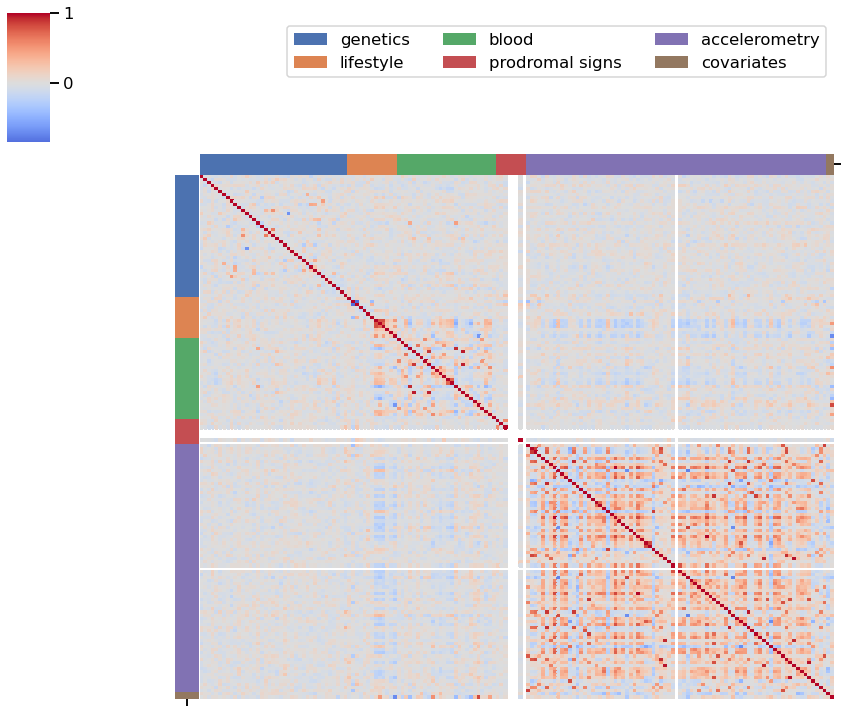

In [10]:
plots.plot_context()
g = sns.clustermap(corr.astype(float),cmap='coolwarm',center=0,col_cluster=False,row_cluster=False,
             row_colors=labels.map(color_map),col_colors=labels.map(color_map),figsize=(12,10),xticklabels=False,yticklabels=False)
# Draw the legend bar for the classes                 
for label in labels.unique():
    g.ax_col_dendrogram.bar(0, 0, color=color_map[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(bbox_to_anchor=(1,1), ncol=3);
plt.savefig('/scratch/c.c21013066/images/paper/ProdromalUKBB/features_modality_corr.png',bbox_inches='tight',dpi=300)
plt.savefig('/scratch/c.c21013066/images/paper/ProdromalUKBB/features_modality_corr.pdf',bbox_inches='tight',dpi=300)

In [26]:
# find PCs for each modality
for label,cols in zip(labels.unique()[:-1],[genetics,lifestyle,blood,prod,allfeatures]):
    print(label,len(cols))
    pcs,variance = get_PCs(hc[cols],n=2)
    print(variance)
    print(pcs.shape)
    hc[f'{label}_1'] = pcs[:,0]
    try:
        hc[f'{label}_2'] = pcs[:,1]
    except:
        pass

genetics 39
[0.0722312  0.06856612]
(266, 2)
lifestyle 13
[0.38936415 0.14116691]
(266, 2)
blood 26
[0.16105211 0.12191228]
(266, 2)
prodromal signs 8
[0.4019018  0.35027117]
(266, 2)
accelerometry 79
[0.2273651  0.11778518]
(266, 2)


/tmp/ipykernel_173141/282147149.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hc[f'{label}_1'] = pcs[:,0]
/tmp/ipykernel_173141/282147149.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hc[f'{label}_2'] = pcs[:,1]
/tmp/ipykernel_173141/282147149.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

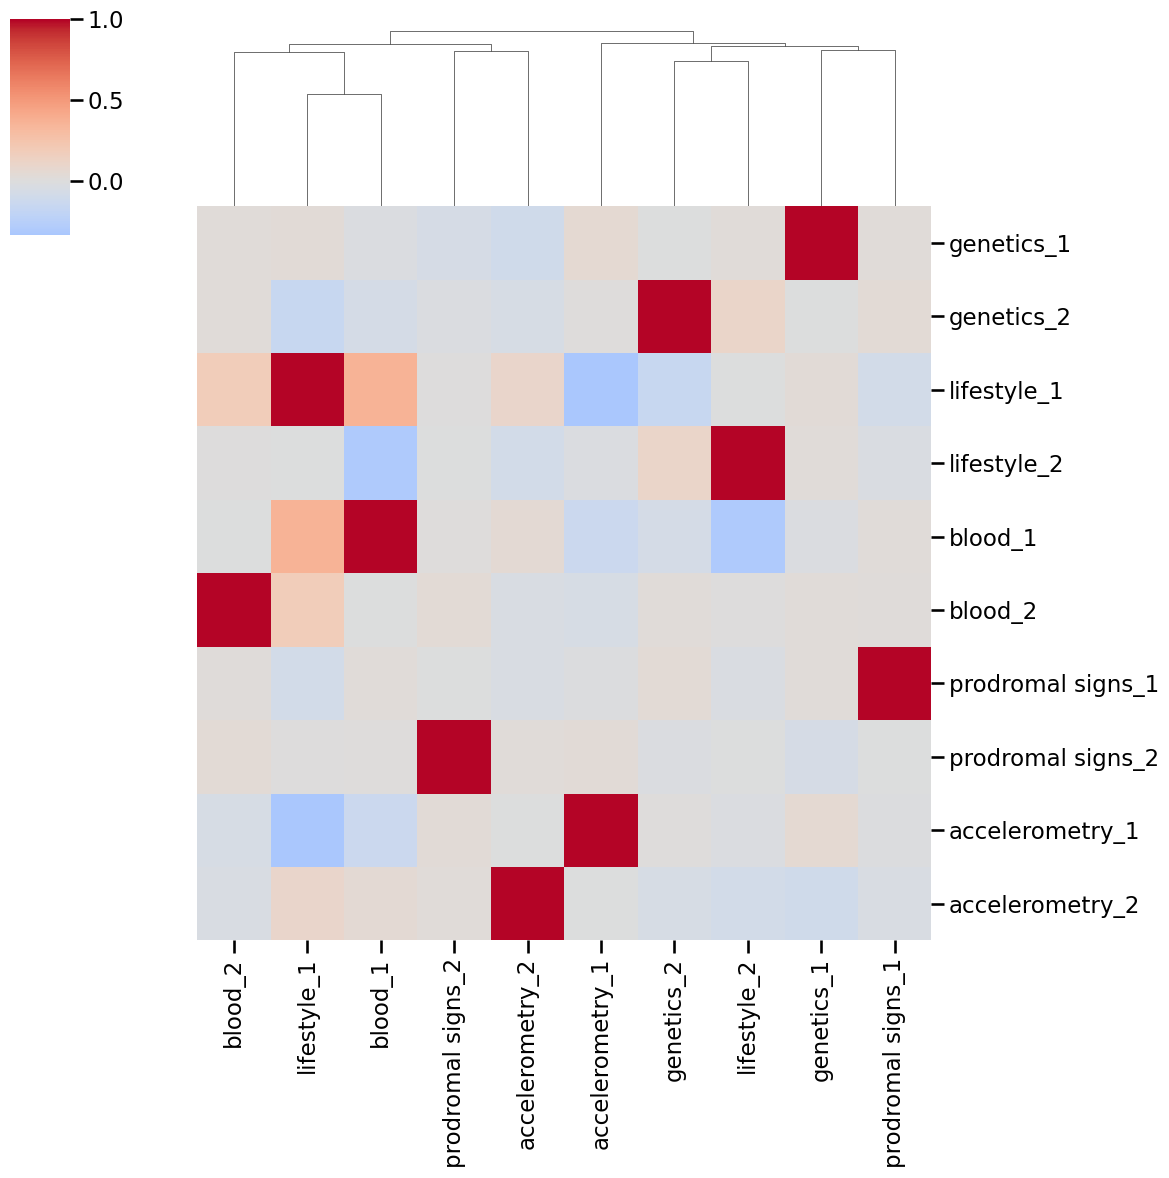

In [27]:
corr = hc.iloc[:,-10:].corr()
plots.plot_context()
g = sns.clustermap(corr.astype(float),cmap='coolwarm',center=0,figsize=(12,12),xticklabels=True,yticklabels=True,row_cluster=False)